# Capstone project

---

Car accident model - based on Data from the UK Department for Transport (2005-2014)

Data files provide detailed road safety data about the circumstances of personal injury road accidents in GB from 2005 to 2014:

- Accident file: main data set contains information about accident severity, weather, location, date, hour, day of week, road type…
- Vehicle file: contains information about vehicle type, vehicle model, engine size, driver sex, driver age, car age…
- Casualty file: contains information about casualty severity, age, sex social class, casualty type, pedestrian or car passenger…

---


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!pip install scikit-learn
print('Scikit-learn lib Installed!')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

Scikit-learn lib Installed!


### 0. Loading data

Loading data for each .csv data file available and dropping columns that wouldn't look as adequate or specially relevant to build a model.

In [2]:
df_accidents = pd.read_csv('Accidents0514.csv')

atrib_to_drop_df_accidents = ['Location_Easting_OSGR','Location_Northing_OSGR','Longitude','Latitude',
                             'Police_Force','Pedestrian_Crossing-Human_Control','Pedestrian_Crossing-Physical_Facilities',
                             'Special_Conditions_at_Site','Carriageway_Hazards','Did_Police_Officer_Attend_Scene_of_Accident','LSOA_of_Accident_Location',
                             '1st_Road_Class','1st_Road_Number','Junction_Detail','Junction_Control','2nd_Road_Class','2nd_Road_Number',
                             'Number_of_Vehicles','Local_Authority_(District)','Local_Authority_(Highway)','Road_Type']

df_accidents.drop(columns = atrib_to_drop_df_accidents, inplace=True)

C:\Users\Sergio\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_vehicles = pd.read_csv('Vehicles0514.csv')

atrib_to_drop_df_vehicles = ['Towing_and_Articulation','Vehicle_Manoeuvre','Vehicle_Location-Restricted_Lane','Junction_Location',
                            'Skidding_and_Overturning','Hit_Object_in_Carriageway','Vehicle_Leaving_Carriageway','Hit_Object_off_Carriageway',
                            'Driver_IMD_Decile','Driver_Home_Area_Type','Vehicle_Reference']

df_vehicles.drop(columns = atrib_to_drop_df_vehicles, inplace=True)

In [4]:
df_casualties = pd.read_csv('Casualties0514.csv')

atrib_to_drop_df_casualties = ['Casualty_Reference','Sex_of_Casualty','Age_of_Casualty','Age_Band_of_Casualty',
                               'Pedestrian_Location','Pedestrian_Movement','Bus_or_Coach_Passenger','Pedestrian_Road_Maintenance_Worker',
                               'Casualty_Home_Area_Type','Vehicle_Reference']

df_casualties.drop(columns = atrib_to_drop_df_casualties, inplace=True)

### 1. Data wrangling

In [5]:
# We join dataframes based on key column
df = df_vehicles.join(df_casualties.set_index('Accident_Index'), on='Accident_Index')
df = df.join(df_accidents.set_index('Accident_Index'), on='Accident_Index')

# According to the data 
df = df.replace(-1,np.NaN)
df.dropna(axis=0,inplace=True)

In [6]:
print(df['Accident_Severity'].value_counts())

3    2412615
2     404590
1      59658
Name: Accident_Severity, dtype: int64


In [7]:
# In the data we have information for different kinds of vehicles, keeping only data for cares stored in value = 9
print(df['Vehicle_Type'].value_counts())

9.0     2362944
19.0     132807
5.0       81035
11.0      65057
8.0       54819
3.0       52886
21.0      50026
2.0       28587
4.0       20789
20.0      13351
10.0       6625
90.0       6183
17.0       1480
98.0        148
97.0        120
23.0          6
Name: Vehicle_Type, dtype: int64


In [8]:
# Only taking car, value = 9 according to tables
df_cars = df.loc[df['Vehicle_Type'] == 9]
df_cars.drop(columns = 'Vehicle_Type', inplace=True)
df_cars.head()

C:\Users\Sergio\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Accident_Index,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,...,Accident_Severity,Number_of_Casualties,Date,Day_of_Week,Time,Speed_limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area
3,200501BS00003,3.0,1.0,15.0,1.0,62.0,9.0,1762.0,1.0,6.0,...,3,1,06/01/2005,5,00:15,30,4,1.0,1.0,1
4,200501BS00004,1.0,1.0,15.0,2.0,49.0,8.0,1769.0,1.0,4.0,...,3,1,07/01/2005,6,10:35,30,1,1.0,1.0,1
6,200501BS00006,0.0,1.0,15.0,1.0,51.0,8.0,2976.0,1.0,1.0,...,3,1,11/01/2005,3,12:40,30,1,2.0,2.0,1
9,200501BS00007,2.0,1.0,15.0,1.0,41.0,7.0,4266.0,1.0,4.0,...,3,1,13/01/2005,5,20:40,30,4,1.0,1.0,1
10,200501BS00009,1.0,1.0,15.0,1.0,68.0,10.0,5343.0,1.0,16.0,...,3,2,14/01/2005,6,17:35,30,1,1.0,1.0,1


In [9]:
# if 0 = driving from right , 1 = left driving
df_cars['Was_Vehicle_Left_Hand_Drive?'].replace({1:0 , 2:1}, inplace=True)

C:\Users\Sergio\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [10]:
# This column wouldn't bring very much info and brings complexity, and reduces generality of the model we want to build
df_cars.drop(columns = 'Journey_Purpose_of_Driver', inplace=True)

C:\Users\Sergio\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
# Removing data values in this column that are set as not specified = 3
df_cars.drop(df_cars.loc[df_cars['Sex_of_Driver']==3].index, inplace=True)

In [12]:
# We already have a categorical clasification in Age_Band_of_Driver so removing this column Age_of_Driver
df_cars.drop(columns = ['Age_of_Driver'], inplace=True)

In [13]:
# This column wouldn't bring very much info and brings complexity, and reduces generality of the model we want to build
df_cars.drop(columns = ['Propulsion_Code'], inplace=True)

In [14]:
# A car tend to have 0-3000 cc 
df_cars.drop(df_cars.loc[df_cars['Engine_Capacity_(CC)'] > 3000].index, inplace=True)
labels = ["{0} - {1}".format(i, i + 999) for i in range(0, 3000, 1000)]
df_cars['Engine_Capacity_(CC)'] = pd.cut(df_cars['Engine_Capacity_(CC)'].values, range(0, 3005, 1000), right=False, labels=labels)
df_cars['Engine_Capacity_(CC)'].replace({"0 - 999": "1", "1000 - 1999": "2" , "2000 - 2999": "3"}, inplace=True)

C:\Users\Sergio\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [15]:
print(df_cars['Engine_Capacity_(CC)'].value_counts())

2    1986446
3     217177
1     114873
Name: Engine_Capacity_(CC), dtype: int64


In [16]:
# Keeping cars that are with an age below 30 (based on fq distribution, most data of the dataset will be conserved)
df_cars.drop(df_cars.loc[df_cars['Age_of_Vehicle'] > 30].index, inplace=True)

In [17]:
# if 0 there is some kind of darkness situation, if 1 daylight
df_cars['Light_Conditions'].replace({1:1 , 4:0 , 5:0, 6:0, 7:0}, inplace=True)

In [18]:
# We keep rows that have defined values for Weather_Conditions
df_cars.drop(df_cars.loc[df_cars['Weather_Conditions'] > 7].index, inplace=True)
df_cars['Weather_Conditions'].value_counts()

1.0    1821288
2.0     306402
5.0      36015
4.0      30399
3.0      18162
7.0      17341
6.0       3583
Name: Weather_Conditions, dtype: int64

In [19]:
# We set new categories (simplified) => 1 = dry , 2 = wet , 3 = ice/snow related
df_cars['Road_Surface_Conditions'].replace({1:1 , 2:2 , 3:3, 4:3, 5:2}, inplace=True)

In [20]:
# 1 = urban, 2 = small town, 3 = rural => most of data are city => will not remove it
df_cars['Urban_or_Rural_Area'].value_counts()

1    1270822
2     962245
3        123
Name: Urban_or_Rural_Area, dtype: int64

In [21]:
# Accident ID can be drop now
df_cars.drop(columns = 'Accident_Index', inplace=True)

In [22]:
# We see the types of data we have and later replace data type accordingly if needed
df_cars.dtypes

1st_Point_of_Impact             float64
Was_Vehicle_Left_Hand_Drive?    float64
Sex_of_Driver                   float64
Age_Band_of_Driver              float64
Engine_Capacity_(CC)             object
Age_of_Vehicle                  float64
Casualty_Class                    int64
Casualty_Severity                 int64
Car_Passenger                   float64
Casualty_Type                     int64
Accident_Severity                 int64
Number_of_Casualties              int64
Date                             object
Day_of_Week                       int64
Time                             object
Speed_limit                       int64
Light_Conditions                  int64
Weather_Conditions              float64
Road_Surface_Conditions         float64
Urban_or_Rural_Area               int64
dtype: object

In [23]:
# We replace data type float for int
df_cars.dropna(axis=0,inplace=True)
df_cars = df_cars.astype({'1st_Point_of_Impact': int, 
                          'Was_Vehicle_Left_Hand_Drive?': int,
                          'Sex_of_Driver': int,
                          'Age_Band_of_Driver': int,
                          'Age_of_Vehicle': int,
                          'Car_Passenger': int,
                          'Weather_Conditions': int,
                          'Road_Surface_Conditions': int,
                          'Engine_Capacity_(CC)': int})

C:\Users\Sergio\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
# Date is object, we make it datetime object in order to later extract month
df_cars['Date']= pd.to_datetime(df_cars['Date'])

# Extracting month from Date
df_cars['Month'] = df_cars['Date'].dt.month

# Droping Date now
df_cars.drop(columns = ['Date'], inplace=True)

In [25]:
# Arranging the order of the columns in the df_cars so that is easier to understand
df_cars = df_cars[['Age_Band_of_Driver','Sex_of_Driver','Was_Vehicle_Left_Hand_Drive?','Engine_Capacity_(CC)',
                   'Age_of_Vehicle','Light_Conditions','Weather_Conditions','Road_Surface_Conditions',
                   'Urban_or_Rural_Area','Time','Day_of_Week','Month','1st_Point_of_Impact','Speed_limit','Casualty_Class','Casualty_Severity',
                   'Car_Passenger','Casualty_Type','Number_of_Casualties','Accident_Severity']]

In [26]:
# In case some rows would be duplicated we remove them
df_cars = df_cars.drop_duplicates()

In [27]:
# Casualty_Type, Number_of_Casualties, Car_Passenger => after further analysis those columns seem to contain redundant or not very relevant information
df_cars.drop(columns = ['Casualty_Type','Number_of_Casualties','Car_Passenger','Time'], inplace=True)
df_cars.head()

,Age_Band_of_Driver,Sex_of_Driver,Was_Vehicle_Left_Hand_Drive?,Engine_Capacity_(CC),Age_of_Vehicle,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Day_of_Week,Month,1st_Point_of_Impact,Speed_limit,Casualty_Class,Casualty_Severity,Accident_Severity
3,9,1,0,2,6,0,1,1,1,5,6,3,30,1,3,3
4,8,2,0,2,4,1,1,1,1,6,7,1,30,3,3,3
6,8,1,0,3,1,1,2,2,1,3,11,0,30,1,3,3
11,6,1,0,2,13,0,1,1,1,7,1,2,30,1,3,3
15,6,1,0,2,6,0,1,1,1,1,1,1,30,3,3,3


In [28]:
# Accident_Severity and Casualty_Severity should be equal, checking to see if we can remove one of the columns
print(df_cars['Accident_Severity'].equals(df_cars['Casualty_Severity']))

False


In [29]:
# Accident_Severity and Casualty_Severity are not equal according to analysis, therefore need to remove those rows do not have equal values for those columns
df_cars.drop(df_cars.index[df_cars['Accident_Severity'] != df_cars['Casualty_Severity']], inplace = True)
df_cars.drop(columns = ['Casualty_Severity'], inplace=True)
print(df['Accident_Severity'].value_counts())

3    2412615
2     404590
1      59658
Name: Accident_Severity, dtype: int64


In [30]:
# Reseting indexes and visualizing final df_cars
df_cars.reset_index(drop=True).head()

,Age_Band_of_Driver,Sex_of_Driver,Was_Vehicle_Left_Hand_Drive?,Engine_Capacity_(CC),Age_of_Vehicle,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Day_of_Week,Month,1st_Point_of_Impact,Speed_limit,Casualty_Class,Accident_Severity
0,9,1,0,2,6,0,1,1,1,5,6,3,30,1,3
1,8,2,0,2,4,1,1,1,1,6,7,1,30,3,3
2,8,1,0,3,1,1,2,2,1,3,11,0,30,1,3
3,6,1,0,2,13,0,1,1,1,7,1,2,30,1,3
4,6,1,0,2,6,0,1,1,1,1,1,1,30,3,3


In [31]:
# Checking nº rowns/columns conserved
df_cars.shape

(1739737, 15)

In [32]:
# We drop some more columns and check shape of the df_cars
df_cars.drop(columns = ['Was_Vehicle_Left_Hand_Drive?','Casualty_Class'], inplace=True)

print(df_cars.shape)

# We save the final dataset cars.csv
df_cars.to_csv('cars.csv',index=False)

(1739737, 13)


### 2. Data Analysis

In [33]:
# Visualizing the final df_cars
df_cars = pd.read_csv('cars.csv')
df_cars.head()

,Age_Band_of_Driver,Sex_of_Driver,Engine_Capacity_(CC),Age_of_Vehicle,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Day_of_Week,Month,1st_Point_of_Impact,Speed_limit,Accident_Severity
0,9,1,2,6,0,1,1,1,5,6,3,30,3
1,8,2,2,4,1,1,1,1,6,7,1,30,3
2,8,1,3,1,1,2,2,1,3,11,0,30,3
3,6,1,2,13,0,1,1,1,7,1,2,30,3
4,6,1,2,6,0,1,1,1,1,1,1,30,3


In [34]:
# We prove that the variables conserved have an interesting correlation with the outcome of the accident = severity
# Note that Age_Band_of_Driver and Age_of_vehicle have a significant negative correlation with Accident_Severity
# Note also that Sex_of_Driver and Light_Conditions have a significant positive impact in the Accident_Severity
df_cars.corr()

,Age_Band_of_Driver,Sex_of_Driver,Engine_Capacity_(CC),Age_of_Vehicle,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Day_of_Week,Month,1st_Point_of_Impact,Speed_limit,Accident_Severity
Age_Band_of_Driver,1.000000,-0.029886,0.094901,-0.082616,0.134417,-0.023566,-0.049667,0.012485,0.001369,0.005146,0.030895,-0.008498,-0.027291
Sex_of_Driver,-0.029886,1.000000,-0.113215,-0.068296,0.094398,-0.002108,-0.001621,-0.011080,-0.000699,-0.000955,0.026440,-0.026697,0.034634
Engine_Capacity_(CC),0.094901,-0.113215,1.000000,-0.017734,0.005861,-0.002923,-0.008668,0.032434,0.001513,0.000067,0.001683,0.034532,-0.012945
Age_of_Vehicle,-0.082616,-0.068296,-0.017734,1.000000,-0.033453,0.004195,0.016332,-0.016006,-0.000700,-0.005513,-0.030437,-0.039183,-0.011220
Light_Conditions,0.134417,0.094398,0.005861,-0.033453,1.000000,-0.117886,-0.189560,0.020060,-0.007927,-0.049415,0.017987,-0.006574,0.043947
Weather_Conditions,-0.023566,-0.002108,-0.002923,0.004195,-0.117886,1.000000,0.434497,0.065209,-0.001900,0.032006,-0.021132,0.073224,0.008131
Road_Surface_Conditions,-0.049667,-0.001621,-0.008668,0.016332,-0.189560,0.434497,1.000000,0.098693,-0.006596,0.059840,-0.039249,0.094831,0.010457
Urban_or_Rural_Area,0.012485,-0.011080,0.032434,-0.016006,0.020060,0.065209,0.098693,1.000000,-0.010765,0.005553,-0.056088,0.671885,-0.023100
Day_of_Week,0.001369,-0.000699,0.001513,-0.000700,-0.007927,-0.001900,-0.006596,-0.010765,1.000000,-0.000164,-0.000439,-0.008686,0.001660
Month,0.005146,-0.000955,0.000067,-0.005513,-0.049415,0.032006,0.059840,0.005553,-0.000164,1.000000,-0.003530,0.007643,-0.001936


We need now to analyze the selected variables vs Accident_Severity to decide thresholding and improve categorization of the data

#### 2.0. Accdent_Severity

In [35]:
# We change arrange the values of Accident_Severity column so that a multiclass model can be built next
df_cars['Accident_Severity'].replace({1:0 , 2:1 , 3:2}, inplace=True)

#### 2.1. Age_Band_of_Driver

In [45]:
x = df_cars['Accident_Severity'].values
y = df_cars['Age_Band_of_Driver'].values

(array([3.00000e+00, 1.00000e+01, 4.19000e+02, 2.02977e+05, 2.41859e+05,
        3.95781e+05, 3.54616e+05, 2.51758e+05, 1.54489e+05, 1.37825e+05]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <a list of 10 Patch objects>)

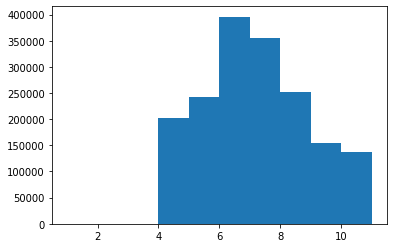

In [46]:
#plt.subplot(121)
plt.hist(df_cars['Age_Band_of_Driver'])

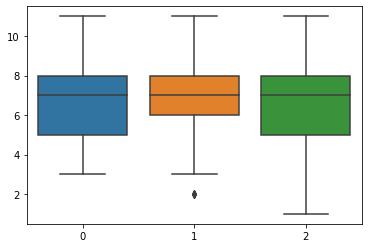

In [48]:
sns.boxplot(x=x, y=y)

In [50]:
df_cars['Age_Band_of_Driver'].replace({4:0 , 5:0 , 6:1, 7:1, 8:2, 9:2, 10:2, 11:2}, inplace=True)

#### Age_of_Vehicle

(array([373983., 401358., 418609., 340356., 150428.,  40550.,   9931.,
          2980.,   1084.,    458.]),
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ]),
 <a list of 10 Patch objects>)

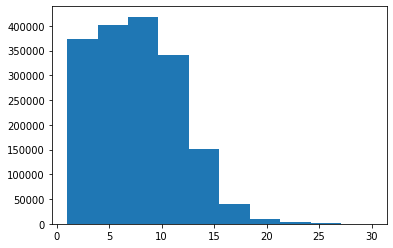

In [53]:
plt.hist(df_cars['Age_of_Vehicle'])

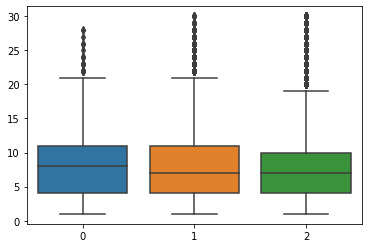

In [52]:
y = df_cars['Age_of_Vehicle'].values
sns.boxplot(x=x, y=y)

In [54]:
df_cars['Age_of_Vehicle'].replace({1:0 , 2:0 , 3:0, 4:0, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1,
                                 11:1, 12:2, 13:2, 14:2, 15:2, 16:2, 17:2, 18:2, 19:2, 20:2,
                                  21:2, 22:2, 23:2, 24:2, 25:2, 26:2, 27:2, 28:2, 29:2, 30:2}, inplace=True)

### 3. Modeling

#### 3.1. Logistic regression: with all values

If we take all the values we will get a model that is good to predict low severity accidents BUT will not predict other scenarios:

In [ ]:
# We prepare X and y
cars = df_cars.values
n,m = cars.shape

X = cars[:,0:m-1]
y = cars[:,m-1]

# We normalize X
X = StandardScaler().fit(X).transform(X)

# We make a partition of the X and y data, to have training and test data --> we use 20% of the data for test purposes and we take them randomly with shuffle = True
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True)

# Let's verify that in the training set we have variety of data between 0 (fatal) and 2 (low severity)
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

# We create the logistic regression model for this multiclass case, and we train it 
clf = LogisticRegression(multi_class = 'multinomial', solver='lbfgs').fit(X, y)

# We use the model to calculate the y_hat values
y_hat = clf.predict(X_test)
y_hat

# We calculate metrics: f1_score and accuracy:
print("Logistic regression f1_score: ", f1_score(y_test,y_hat, average = 'macro'))
print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_hat))

# We display the confusion matrix for visibility:
cm = confusion_matrix(y_test, y_hat)
cm_display = ConfusionMatrixDisplay(cm).plot()

#### 3.2. Logistic regression and decision tree: taking equilibrated subset of data

In [55]:
# We now just take a subset of the data so that we have now equilibrated amount of severity accidents between 0, 1 and 2
a = df_cars.loc[df_cars['Accident_Severity'] == 0].values
b = df_cars.loc[df_cars['Accident_Severity'] == 1].values
c = df_cars.loc[df_cars['Accident_Severity'] == 2].values
a = a[0:7500,]
b = b[0:7500,]
c = c[0:7500,]
new_cars = np.concatenate([a,b,c],axis=0)
n,m = new_cars.shape
X = new_cars[:,0:m-1]
y = new_cars[:,m-1]

In [56]:
# Logistic Regression
# We create the logistic regression model for this multiclass case, and we train it 
# We use the model to calculate the y_hat values
# We calculate metrics: f1_score
X = StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True)
clf = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', class_weight={0:2,1:1,2:1}).fit(X, y)
y_hat = clf.predict(X_test)
print("logisticRegression f1_score: ", f1_score(y_test,y_hat, average = 'macro'))
print("logisticRegression Accuracy: ", accuracy_score(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat)
cm_display = ConfusionMatrixDisplay(cm).plot()

logisticRegression f1_score:  0.42552929436185405
logisticRegression Accuracy:  0.5130370370370371


NameError: name 'ConfusionMatrixDisplay' is not defined

In [687]:
cmfor0 = cm[0,0]/np.sum(cm[0,]); print(cmfor0)
cmfor1 = cm[1,1]/np.sum(cm[1,]); print(cmfor1)
cmfor2 = cm[2,2]/np.sum(cm[2,]); print(cmfor2)

0.7588843904633378
0.013531209079004802
0.8202146690518783


logisticRegression f1_score:  0.6377365602486327
logisticRegression Accuracy:  0.6377777777777778
0.6180464301357862
0.6580965268380695


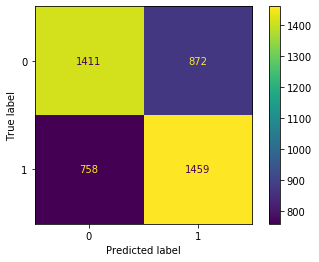

In [688]:
df_cars['Accident_Severity'].replace({0:0 , 1:1 , 2:1})
a = df_cars.loc[df_cars['Accident_Severity'] == 0].values
b = df_cars.loc[df_cars['Accident_Severity'] == 1].values

a = a[0:7500,]
b = b[0:7500,]

new_cars = np.concatenate([a,b],axis=0)
n,m = new_cars.shape
X = new_cars[:,0:m-1]
y = new_cars[:,m-1]
X = StandardScaler().fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True)
clf = LogisticRegression(solver='lbfgs').fit(X, y)
y_hat = clf.predict(X_test)

print("logisticRegression f1_score: ", f1_score(y_test,y_hat, average = 'macro'))
print("logisticRegression Accuracy: ", accuracy_score(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat)
cm_display = ConfusionMatrixDisplay(cm).plot()

cmfor0 = cm[0,0]/np.sum(cm[0,]); print(cmfor0)
cmfor1 = cm[1,1]/np.sum(cm[1,]); print(cmfor1)

In [591]:
# print("logisticRegression f1_score: ", f1_score(y_test,y_hat, average = 'macro'))
# print("logisticRegression Accuracy: ", accuracy_score(y_test, y_hat))
# cm = confusion_matrix(y_test, y_hat)
# cm_display = ConfusionMatrixDisplay(cm).plot()
    
# events = [7500,15000,25000,50000,100000]
# f1 = [0.64,0.56,0.49,0.46,0.48]
# acc = [0.64,0.68,0.76,0.87,0.93]

DecisionTrees's f1_score:  0.6542068536379394
DecisionTrees's Accuracy:  0.6542222222222223


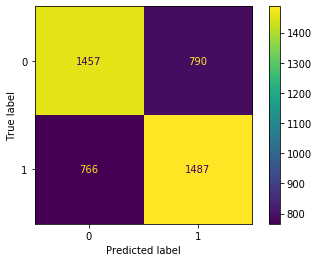

In [596]:
# Decision tree
# DT = tree.DecisionTreeClassifier(criterion="entropy", max_depth = m-2)
# DT = clf.fit(X_train,y_train)
# print("DecisionTrees's f1_score: ", f1_score(y_test,y_hat, average = 'macro'))
# print("DecisionTrees's Accuracy: ", accuracy_score(y_test, y_hat))
# cm = confusion_matrix(y_test, y_hat)
# cm_display = ConfusionMatrixDisplay(cm).plot()